In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN

from keras.layers import Flatten

import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
df = pd.read_csv("ETH-EUR_11_11_2017-07_12_2022.csv")
btc_df = df
print(btc_df.shape)
btc_df.head()

(1853, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-11,256.011322,273.902954,255.673492,269.811371,269.811371,722199256
1,2017-11-12,269.819092,273.739624,255.948730,264.072021,264.072021,1383773530
2,2017-11-13,263.314758,281.949707,263.405121,271.556213,271.556213,893329318
3,2017-11-14,271.596497,290.873871,271.573212,286.394958,286.394958,907354313
4,2017-11-15,286.677399,289.079956,279.644714,282.937531,282.937531,613364441


In [5]:
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace= True)
# data =data.resample('D').mean()

#Unix Timestamp being convert to date format
btc_df.date = pd.to_datetime(btc_df.Date)
btc_df.index = btc_df.date

# btc_df.date = pd.to_datetime(btc_df.Timestamp, unit='s')
# btc_df.index = btc_df.date

#Resample into Daily frequent
#btc_df = btc_df.resample('D').mean()

#Drop row with all Nans / zeros in pandas data frame
btc_df = btc_df.dropna()

print(btc_df.shape)
btc_df.head()

(1853, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2017-11-11,2017-11-11,256.011322,273.902954,255.673492,269.811371,269.811371,722199256
2017-11-12,2017-11-12,269.819092,273.739624,255.948730,264.072021,264.072021,1383773530
2017-11-13,2017-11-13,263.314758,281.949707,263.405121,271.556213,271.556213,893329318
2017-11-14,2017-11-14,271.596497,290.873871,271.573212,286.394958,286.394958,907354313
2017-11-15,2017-11-15,286.677399,289.079956,279.644714,282.937531,282.937531,613364441


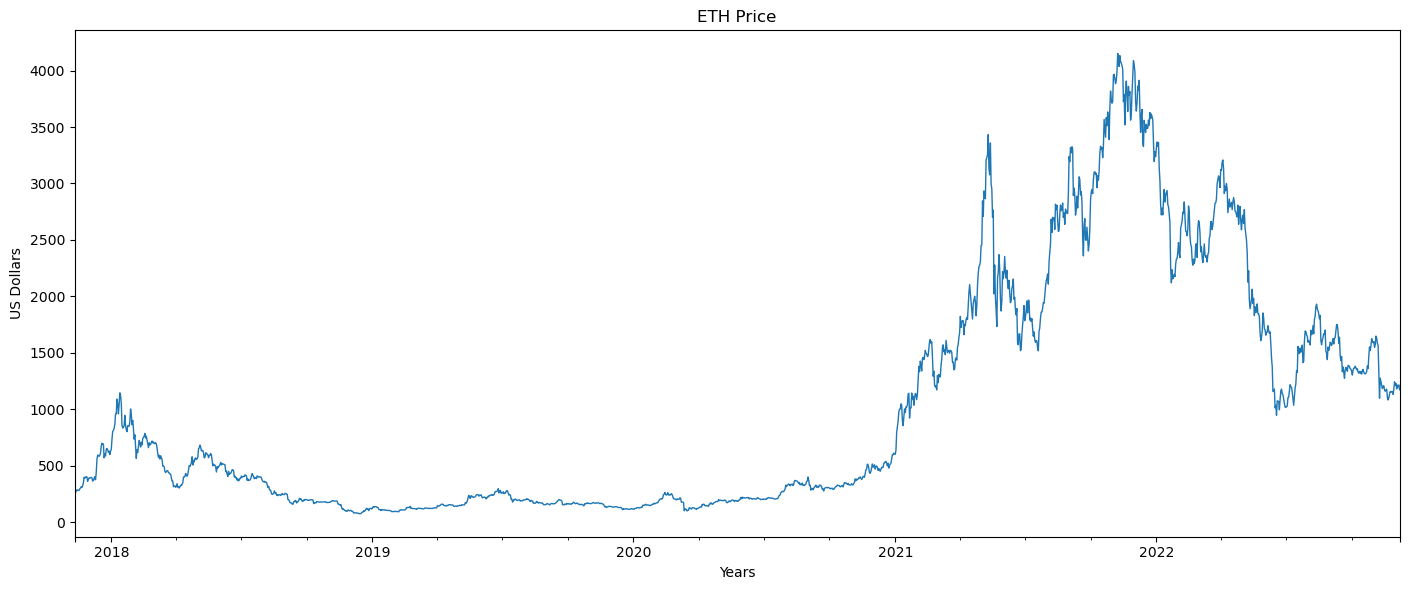

In [6]:
btc_df.Close.plot(title = "ETH Price", figsize=(14,6), linewidth=1)
plt.tight_layout()
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.show()

In [7]:
btc_df = btc_df.drop(['Open', 'Low', 'High', 'Adj Close','Volume', 'Date'], axis = 1)
btc_df.head()

,Close
Date,
2017-11-11,269.811371
2017-11-12,264.072021
2017-11-13,271.556213
2017-11-14,286.394958
2017-11-15,282.937531


In [8]:
btc_df.shape

(1853, 1)

In [9]:
prediction_period = 1500
df_train= btc_df[:len(btc_df)-prediction_period].values.reshape(-1,1)
df_test= btc_df[len(btc_df)-prediction_period:].values.reshape(-1,1)

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [10]:
scaled_train.shape

(353, 1)

In [11]:
scaled_test.shape

(1500, 1)

In [12]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(scaled_train)
testX, testY = create_dataset(scaled_test)

In [13]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
trainX.shape

(352, 1, 1)

In [15]:
testX.shape

(1499, 1, 1)

In [16]:
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import TimeDistributed

In [17]:
regressor = Sequential()
regressor.add(Conv1D(filters=256, kernel_size=1, activation='relu', input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(LSTM(units = 256, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(LSTM(units = 256, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dense(units = 1))
regressor.add(Flatten())
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 256)            512       
                                                                 
 lstm (LSTM)                 (None, 1, 256)            525312    
                                                                 
 lstm_1 (LSTM)               (None, 1, 256)            525312    
                                                                 
 dense (Dense)               (None, 1, 1)              257       
                                                                 
 flatten (Flatten)           (None, 1)                 0         
                                                                 
Total params: 1,051,393
Trainable params: 1,051,393
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 150, verbose=1, shuffle=False)

Epoch 1/150
11/11 [==============================] - 2s 44ms/step - loss: 0.1325
Epoch 2/150
11/11 [==============================] - 0s 46ms/step - loss: 0.0892
Epoch 3/150
11/11 [==============================] - 1s 54ms/step - loss: 0.0328
Epoch 4/150
11/11 [==============================] - 0s 40ms/step - loss: 0.0105
Epoch 5/150
11/11 [==============================] - 0s 37ms/step - loss: 0.0136
Epoch 6/150
11/11 [==============================] - 0s 42ms/step - loss: 0.0073
Epoch 7/150
11/11 [==============================] - 0s 39ms/step - loss: 0.0037
Epoch 8/150
11/11 [==============================] - 0s 38ms/step - loss: 0.0040
Epoch 9/150
11/11 [==============================] - 0s 46ms/step - loss: 0.0026
Epoch 10/150
11/11 [==============================] - 0s 47ms/step - loss: 0.0030
Epoch 11/150
11/11 [==============================] - 0s 42ms/step - loss: 0.0030
Epoch 12/150
11/11 [==============================] - 0s 42ms/step - loss: 0.0036
Epoch 13/150
11/11 [=====

In [19]:
# Making the predictions
predicted_BTC_price = regressor.predict(testX)
predicted_BTC_price = scaler_test.inverse_transform(predicted_BTC_price.reshape(-1, 1))

true = scaler_test.inverse_transform(testY.reshape(-1, 1))


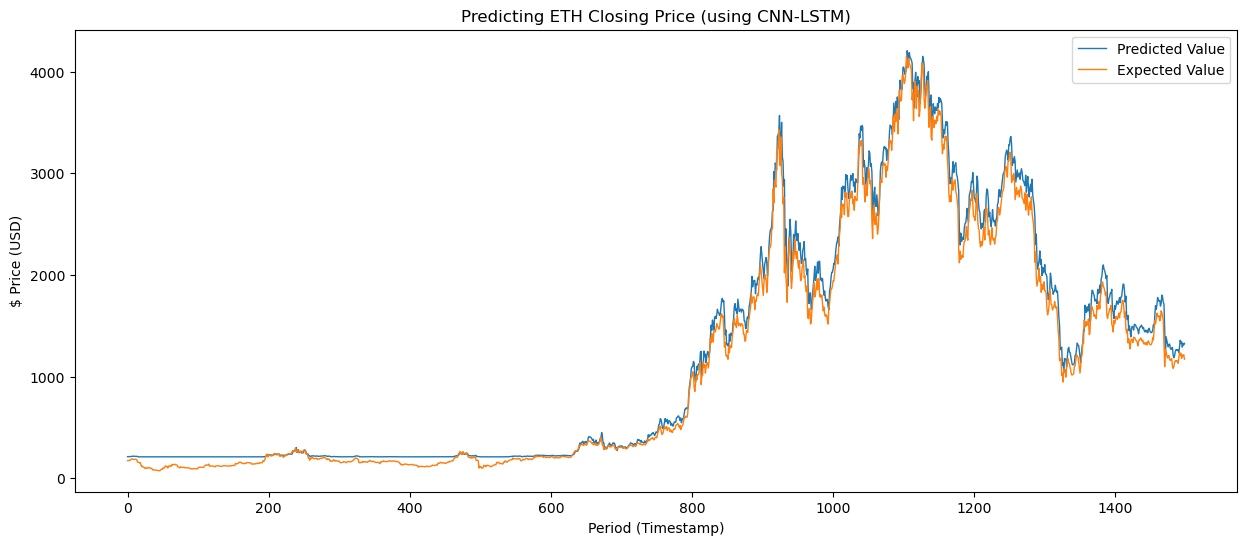

In [20]:
plt.figure(figsize = (15,6))
plt.plot(predicted_BTC_price, label='Predicted Value', linewidth=1)
plt.plot(true, label='Expected Value', linewidth=1)
plt.xlabel('Period (Timestamp)')
plt.ylabel('$ Price (USD)')
plt.title('Predicting ETH Closing Price (using LSTM)')
plt.legend()
plt.show()

In [21]:
rmse = sqrt(mean_squared_error(true, predicted_BTC_price))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 133.059


In [22]:
regressor=Sequential()
#first RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True,input_shape=(trainX.shape[1],trainX.shape[2])))

#third RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True,input_shape=(trainX.shape[1],trainX.shape[2])))

regressor.add(Flatten())
#output layer
regressor.add(Dense(1))

regressor.compile(optimizer="adam",loss="mean_squared_error")
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 256)            66048     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1, 256)            131328    
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 197,633
Trainable params: 197,633
Non-trainable params: 0
_________________________________________________________________


In [23]:
regressor.fit(trainX,trainY,epochs=150,batch_size=32,verbose=0)

In [24]:
# Making the predictions
predicted_BTC_price = regressor.predict(testX)
predicted_BTC_price = scaler_test.inverse_transform(predicted_BTC_price.reshape(-1, 1))

true = scaler_test.inverse_transform(testY.reshape(-1, 1))

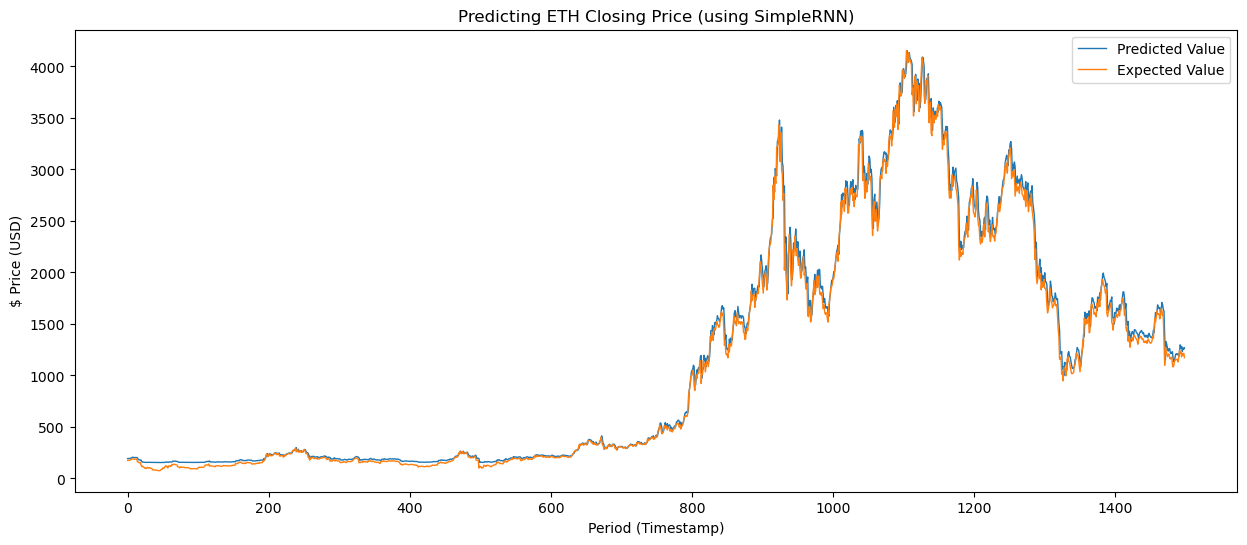

In [25]:
plt.figure(figsize = (15,6))
plt.plot(predicted_BTC_price, label='Predicted Value', linewidth=1)
plt.plot(true, label='Expected Value', linewidth=1)
plt.xlabel('Period (Timestamp)')
plt.ylabel('$ Price (USD)')
plt.title('Predicting ETH Closing Price (using SimpleRNN)')
plt.legend()
plt.show()

In [26]:
rmse = sqrt(mean_squared_error(true, predicted_BTC_price))
print('Test MSE: %.3f' % mean_squared_error(true, predicted_BTC_price))
print('Test RMSE: %.3f' % rmse)

Test MSE: 7432.568
Test RMSE: 86.212


In [27]:
from statsmodels.tsa.arima.model import ARIMA


train = df_train
test = df_test
history = [x for x in train]
predictions = list()

In [28]:
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test MSE: %.3f' % mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=172.904099, expected=174.142456
predicted=174.268843, expected=174.435654
predicted=174.304697, expected=174.397018
predicted=175.009573, expected=176.197662
predicted=175.695751, expected=175.803345
predicted=175.786937, expected=182.019165
predicted=182.469028, expected=183.260529
predicted=183.084831, expected=191.078217
predicted=191.821557, expected=189.936539
predicted=189.252950, expected=186.683914
predicted=187.049200, expected=185.291351
predicted=184.763327, expected=187.475357
predicted=188.318083, expected=186.637741
predicted=186.672949, expected=187.445618
predicted=187.379159, expected=182.837921
predicted=182.245374, expected=160.341705
predicted=159.272930, expected=159.666336
predicted=159.815775, expected=153.387604
predicted=153.058707, expected=152.390076
predicted=153.721588, expected=155.163452
predicted=153.433691, expected=130.244095
predicted=129.036969, expected=114.618942
predicted=113.649266, expected=120.050133
predicted=119.967130, expected=111

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1852
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -10423.137
Date:                Wed, 28 Dec 2022   AIC                          20858.273
Time:                        12:44:42   BIC                          20891.414
Sample:                             0   HQIC                         20870.490
                               - 1852                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0578      0.013     -4.407      0.000      -0.084      -0.032
ar.L2          0.0107      0.012      0.928      0.353      -0.012       0.033
ar.L3          0.0362      0.013      2.850      0.0

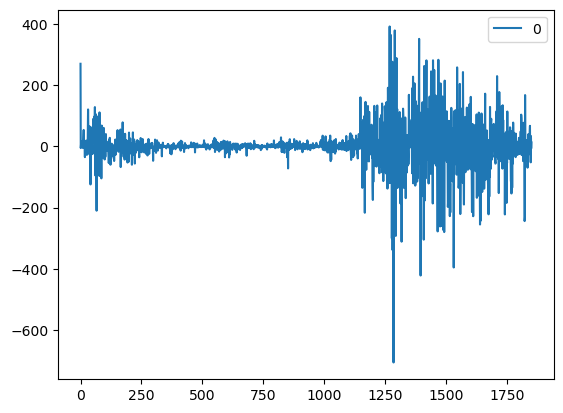

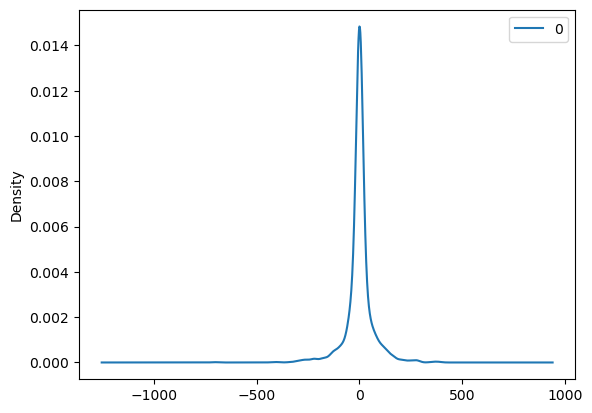

                 0
count  1852.000000
mean      0.680219
std      67.787788
min    -706.456676
25%     -10.767691
50%       0.378717
75%      12.287858
max     391.700414


In [29]:
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

Test RMSE: 74.970


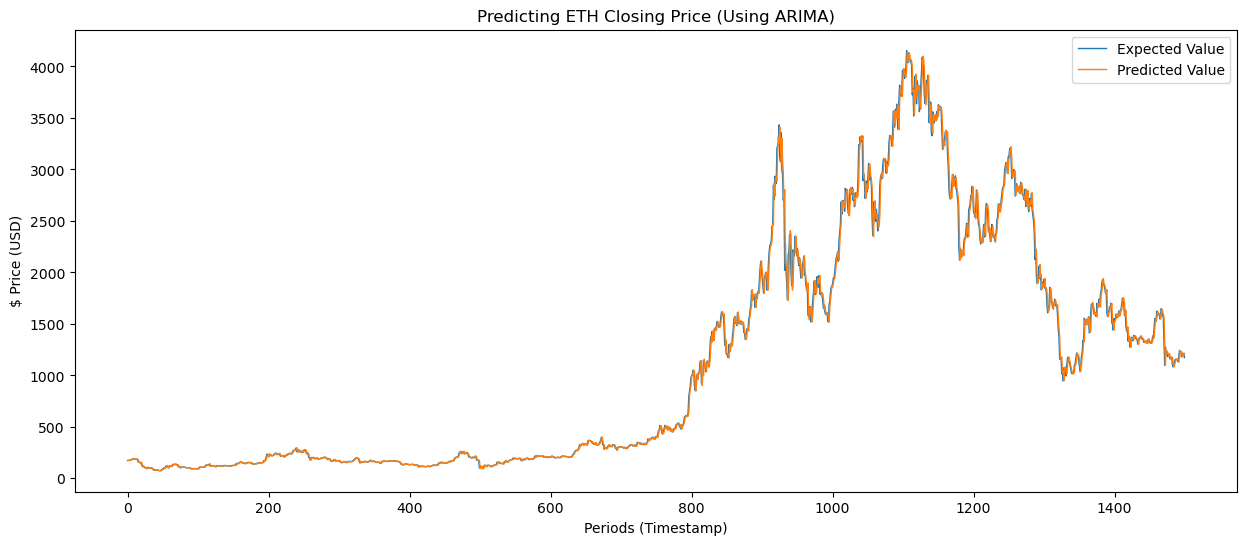

In [30]:
plt.figure(figsize=(15,6))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test, label='Expected Value', linewidth=1)
plt.plot(predictions, label='Predicted Value', linewidth=1)
plt.xlabel('Periods (Timestamp)')
plt.ylabel('$ Price (USD)')
plt.title('Predicting ETH Closing Price (Using ARIMA)')
plt.legend()
plt.show()

In [31]:
df5 = pd.read_csv("ETH-EUR_11_11_2017-07_12_2022.csv")
btc_df5 = df5

btc_df5 = btc_df5.dropna()

print(btc_df5.shape)
btc_df5.head()

(1853, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-11,256.011322,273.902954,255.673492,269.811371,269.811371,722199256
1,2017-11-12,269.819092,273.739624,255.948730,264.072021,264.072021,1383773530
2,2017-11-13,263.314758,281.949707,263.405121,271.556213,271.556213,893329318
3,2017-11-14,271.596497,290.873871,271.573212,286.394958,286.394958,907354313
4,2017-11-15,286.677399,289.079956,279.644714,282.937531,282.937531,613364441


In [32]:

btc_df5.index = btc_df5.Date
btc_df5.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2017-11-11,2017-11-11,256.011322,273.902954,255.673492,269.811371,269.811371,722199256
2017-11-12,2017-11-12,269.819092,273.739624,255.948730,264.072021,264.072021,1383773530
2017-11-13,2017-11-13,263.314758,281.949707,263.405121,271.556213,271.556213,893329318
2017-11-14,2017-11-14,271.596497,290.873871,271.573212,286.394958,286.394958,907354313
2017-11-15,2017-11-15,286.677399,289.079956,279.644714,282.937531,282.937531,613364441


In [33]:
btc_df5 = btc_df5.drop(['Open', 'Low', 'High', 'Adj Close','Volume'], axis = 1)
btc_df5.head()

,Date,Close
Date,,
2017-11-11,2017-11-11,269.811371
2017-11-12,2017-11-12,264.072021
2017-11-13,2017-11-13,271.556213
2017-11-14,2017-11-14,286.394958
2017-11-15,2017-11-15,282.937531


In [34]:
btc_df5.date = pd.to_datetime(btc_df5.Date)
btc_df5.index = btc_df5.date
btc_df5.head()

,Date,Close
Date,,
2017-11-11,2017-11-11,269.811371
2017-11-12,2017-11-12,264.072021
2017-11-13,2017-11-13,271.556213
2017-11-14,2017-11-14,286.394958
2017-11-15,2017-11-15,282.937531


In [35]:
btc_df5 = btc_df5.drop(['Date'], axis = 1)
btc_df5.head()

,Close
Date,
2017-11-11,269.811371
2017-11-12,264.072021
2017-11-13,271.556213
2017-11-14,286.394958
2017-11-15,282.937531


In [36]:
prediction_period = 1500
data_train= btc_df5[:len(btc_df5)-prediction_period]
data_test= btc_df5[len(btc_df5)-prediction_period:]

In [37]:
# a method to create a variety of features from a time series df
def create_features(df, label=None):
    df['date'] = df.index
    df['minute'] = df['date'].dt.minute
    df['hour'] = df['date'].dt.hour
    df['day'] = df['date'].dt.day
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    X = df[['minute','hour','day','quarter','month']]
    if label:
        y = df[label]
        return X, y
    return X

In [38]:
X_train, y_train = create_features(data_train, label='Close')
X_test, y_test = create_features(data_test, label='Close')

In [39]:
X_train.shape

(353, 5)

In [40]:
X_test.shape

(1500, 5)

In [41]:
y_train.shape

(353,)

In [42]:
y_test.shape

(1500,)

In [43]:
# import XGBoost, then create model, and fit it to the training data
import xgboost as xgb
from xgboost import plot_importance, plot_tree
model =  xgb.XGBRegressor(n_estimators = 1000)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=500, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [44]:
# assign predictions to data_test and then data_all
data_test['Closing_Price_Prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

In [45]:
data_test.head()

,Close,date,minute,hour,day,quarter,month,Closing_Price_Prediction
Date,,,,,,,,
2018-10-30,174.142456,2018-10-30,0,0,30,4,10,180.118393
2018-10-31,174.435654,2018-10-31,0,0,31,4,10,180.929337
2018-11-01,174.397018,2018-11-01,0,0,1,4,11,279.927856
2018-11-02,176.197662,2018-11-02,0,0,2,4,11,279.944397
2018-11-03,175.803345,2018-11-03,0,0,3,4,11,279.593536


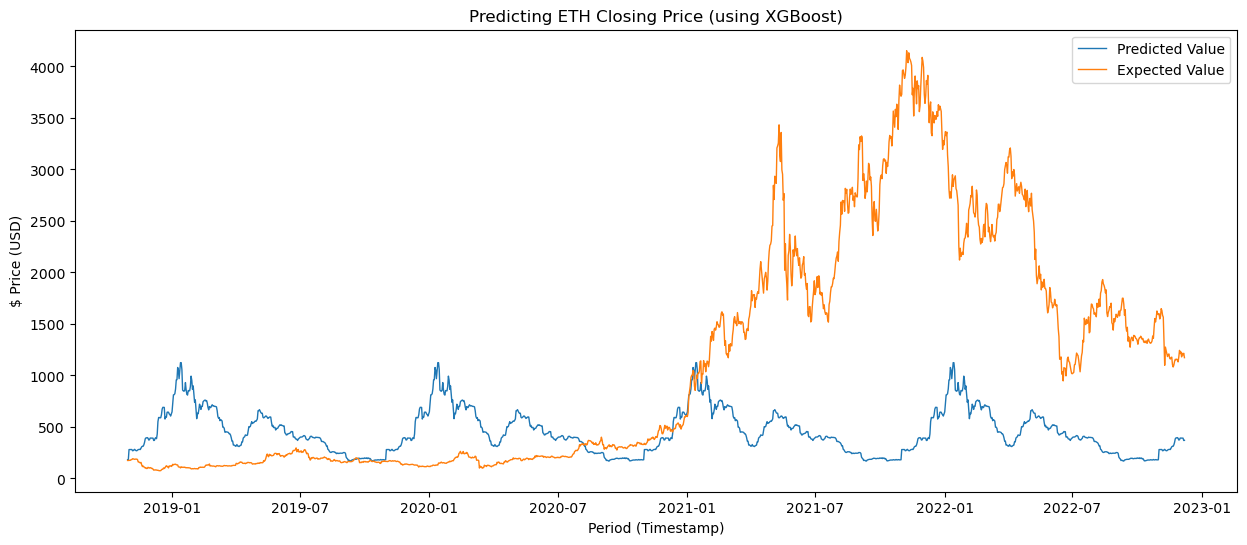

In [46]:
plt.figure(figsize = (15,6))
plt.plot(data_test['Closing_Price_Prediction'], label='Predicted Value', linewidth=1)
plt.plot(data_test['Close'], label='Expected Value', linewidth=1)
plt.xlabel('Period (Timestamp)')
plt.ylabel('$ Price (USD)')
plt.title('Predicting ETH Closing Price (using XGBoost)')
plt.legend()
plt.show()

In [47]:
rmse = np.sqrt(mean_squared_error(data_test['Close'], data_test['Closing_Price_Prediction']))
print('Test MSE: %.3f' % mean_squared_error(data_test['Close'], data_test['Closing_Price_Prediction']))
print('Test RMSE: %.3f' % rmse)

Test MSE: 1780551.126
Test RMSE: 1334.373


In [48]:
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM, Flatten, Embedding

In [49]:
model = Sequential()
model.add(BatchNormalization(input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.4, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.4, activation='relu', return_sequences=True)))
model.add(Flatten())
model.add(Dense(1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 1, 1)             4         
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 1, 256)           133120    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 256)           394240    
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                      

In [50]:
history = model.fit(trainX, trainY, batch_size = 32, epochs = 150, verbose=1, shuffle=False)

Epoch 1/150
11/11 [==============================] - 5s 8ms/step - loss: 0.1329 - mean_squared_error: 0.1329
Epoch 2/150
11/11 [==============================] - 0s 8ms/step - loss: 0.0953 - mean_squared_error: 0.0953
Epoch 3/150
11/11 [==============================] - 0s 8ms/step - loss: 0.0651 - mean_squared_error: 0.0651
Epoch 4/150
11/11 [==============================] - 0s 8ms/step - loss: 0.0543 - mean_squared_error: 0.0543
Epoch 5/150
11/11 [==============================] - 0s 8ms/step - loss: 0.0453 - mean_squared_error: 0.0453
Epoch 6/150
11/11 [==============================] - 0s 8ms/step - loss: 0.0442 - mean_squared_error: 0.0442
Epoch 7/150
11/11 [==============================] - 0s 8ms/step - loss: 0.0447 - mean_squared_error: 0.0447
Epoch 8/150
11/11 [==============================] - 0s 8ms/step - loss: 0.0423 - mean_squared_error: 0.0423
Epoch 9/150
11/11 [==============================] - 0s 8ms/step - loss: 0.0473 - mean_squared_error: 0.0473
Epoch 10/150
11/11 

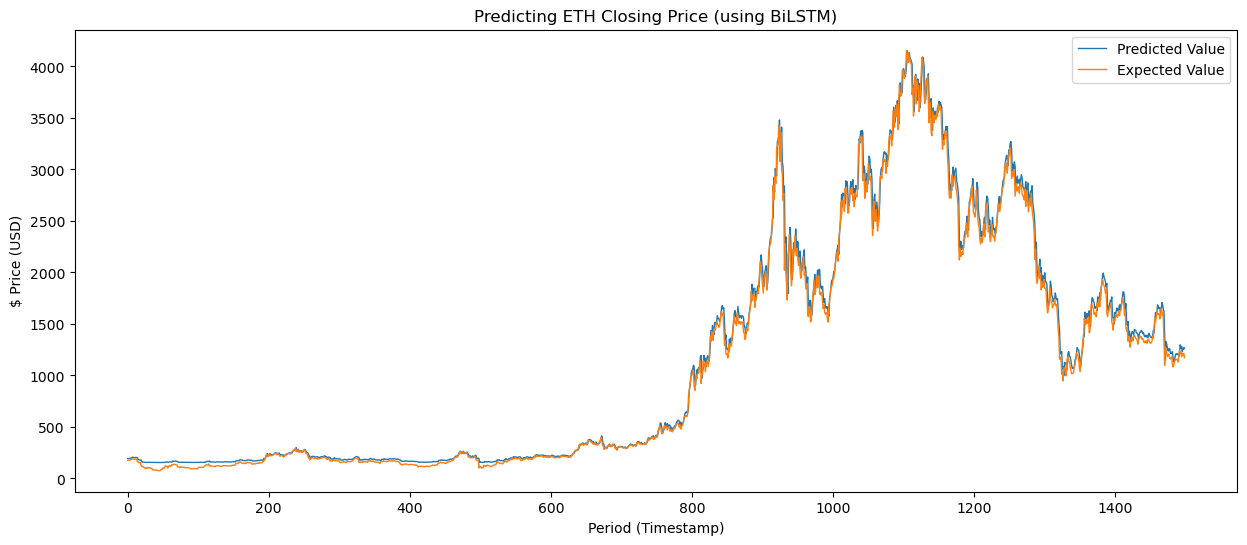

In [51]:
plt.figure(figsize = (15,6))
plt.plot(predicted_BTC_price, label='Predicted Value', linewidth=1)
plt.plot(true, label='Expected Value', linewidth=1)
plt.xlabel('Period (Timestamp)')
plt.ylabel('$ Price (USD)')
plt.title('Predicting ETH Closing Price (using BiLSTM)')
plt.legend()
plt.show()

In [52]:
rmse = sqrt(mean_squared_error(true, predicted_BTC_price))
print('Test MSE: %.3f' % mean_squared_error(true, predicted_BTC_price))
print('Test RMSE: %.3f' % rmse)

Test MSE: 7432.568
Test RMSE: 86.212


In [53]:
history = model.fit(trainX, trainY, batch_size = 16, epochs = 150, verbose=0, shuffle=False)

In [59]:
# Making the predictions
predicted_BTC_price = model.predict(testX)
predicted_BTC_price = scaler_test.inverse_transform(predicted_BTC_price.reshape(-1, 1))

true = scaler_test.inverse_transform(testY.reshape(-1, 1))

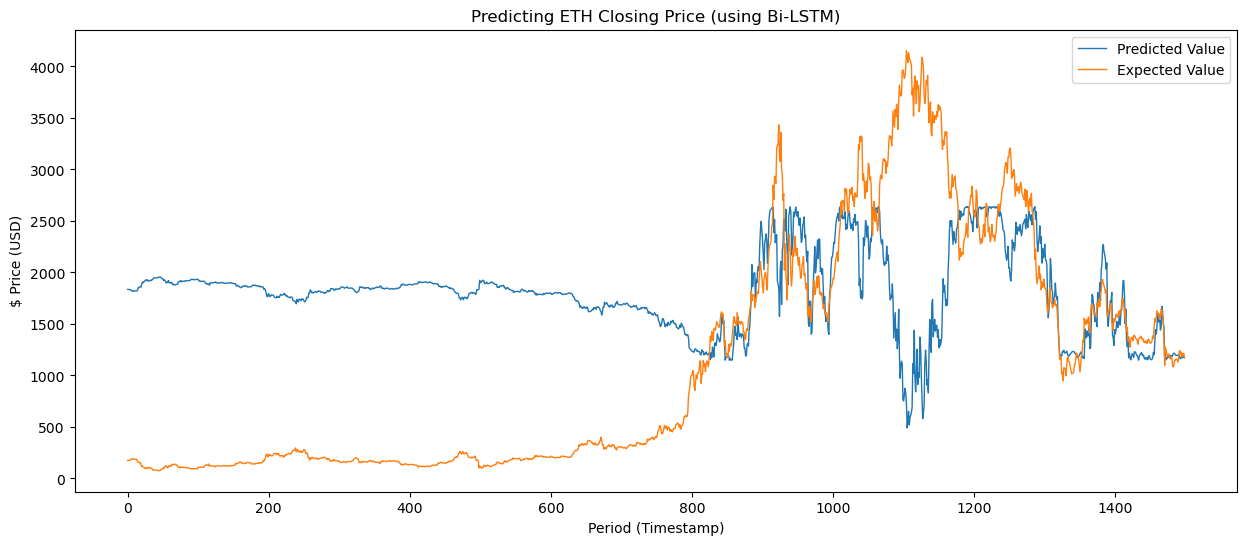

In [60]:
plt.figure(figsize = (15,6))
plt.plot(predicted_BTC_price, label='Predicted Value', linewidth=1)
plt.plot(true, label='Expected Value', linewidth=1)
plt.xlabel('Period (Timestamp)')
plt.ylabel('$ Price (USD)')
plt.title('Predicting ETH Closing Price (using Bi-LSTM)')
plt.legend()
plt.show()

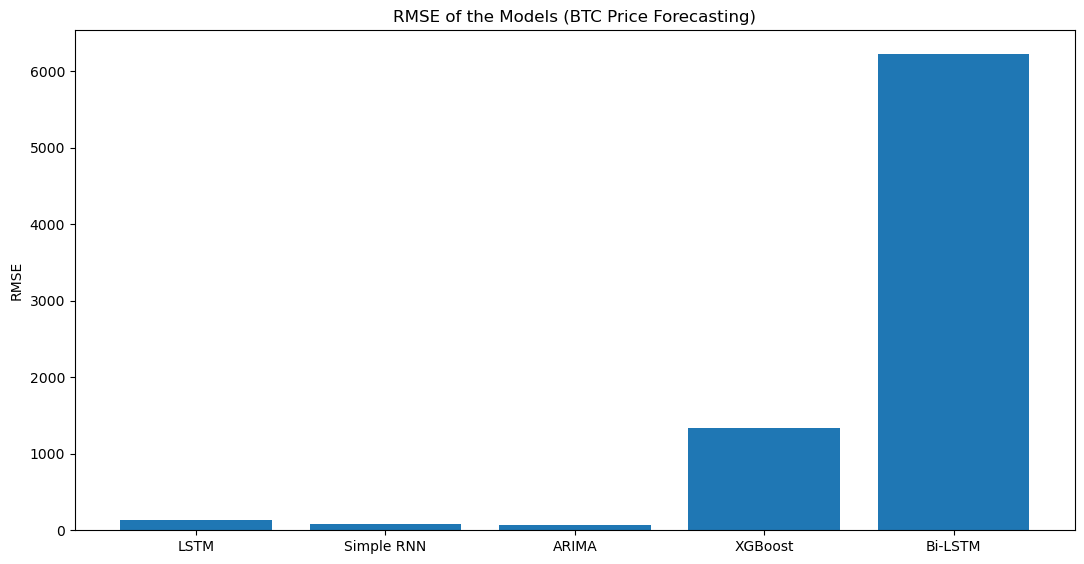

In [56]:
# Final graph for the RMSE's of each model
fig = plt.figure(figsize = (10,5))
ax = fig.add_axes([0,0,1,1])
modelz = ['LSTM','Simple RNN','ARIMA','XGBoost', 'Bi-LSTM']
nums = [135.540,78.905,74.970,1334.373,6226.038]
ax.bar(modelz,nums)
plt.ylabel('RMSE')
plt.title('RMSE of the Models (BTC Price Forecasting)')
plt.show()
plt.show()